In [14]:
#文章を入力するとそれをコーパスとして整えてくれる関数
def preprocess(text):
    text = text.lower() #すべて小文字に
    text = text.replace(',', ' ,') #スペースごとに文字を区切るためピリオドを調節
    words = text.split(' ') #スペースごとに分割

    word_to_id = {} #wordをキー，idをvalueとする辞書
    id_to_word = {} #idをキー，wordをvalueとする辞書
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id) #辞書にない単語の場合，辞書の末尾に新しい単語を加える（最新のid）
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[word] for word in words])
    return corpus, word_to_id, id_to_word

In [15]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word) #短い文章をコーパスとして整形できた

[0 1 2 3 4 1 5]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello.': 5}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello.'}


In [33]:
#共起行列を作成する関数
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

#相互情報量の計算
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成

    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C) #共起行列に含まれる単語の個数
    S = np.sum(C, axis=0)#↓方向に足し算
    #S[i]はi番目の単語の出現回数に相当する
    #C[i, j]はi番目の単語とj番目の単語の共起回数
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


In [19]:
#共起行列を相互情報の行列に改良
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print('co-occurrence matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)
#各行（列）が各単語を表すベクトルになっている（値が大きいの単語同士の関連性が高いことに相当）

co-occurrence matrix
[[0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 1 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.585 0.    0.    0.    0.   ]
 [1.585 0.    0.585 0.    0.585 1.585]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    0.    1.585 0.    1.585 0.   ]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    1.585 0.    0.    0.    0.   ]]


In [30]:
#↑の例では，コーパスの大きさが増えるほどベクトルの次元数が増加する．
#↑のppmi行列がほとんど疎なのに着目して次元圧縮を行う
#特異値分解（SVD）

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
#ppmi行列を特異値分解により次元圧縮する
U, S, V = np.linalg.svd(W)
print(U) #密なベクトルが入ってる
#次元削減する場合は列数を削減すれば良い
print('次元削減後のベクトル', U[:, :2])

[[-4.524e-01  0.000e+00  0.000e+00 -5.435e-01  1.834e-01 -6.829e-01]
 [ 5.551e-17 -7.686e-01  6.397e-01  0.000e+00  0.000e+00  0.000e+00]
 [-5.435e-01  2.219e-17  5.555e-17  4.524e-01  6.829e-01  1.834e-01]
 [-1.110e-16 -6.397e-01 -7.686e-01  0.000e+00  0.000e+00  0.000e+00]
 [-5.435e-01  2.219e-17  5.555e-17  4.524e-01 -6.829e-01 -1.834e-01]
 [-4.524e-01  1.324e-17  3.315e-17 -5.435e-01 -1.834e-01  6.829e-01]]
次元削減後のベクトル [[-4.524e-01  0.000e+00]
 [ 5.551e-17 -7.686e-01]
 [-5.435e-01  2.219e-17]
 [-1.110e-16 -6.397e-01]
 [-5.435e-01  2.219e-17]
 [-4.524e-01  1.324e-17]]


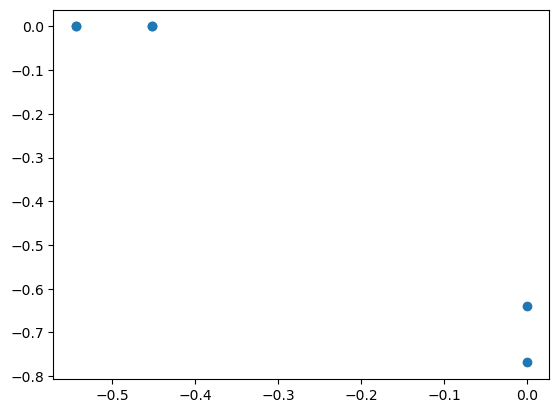

In [29]:
import matplotlib.pyplot as plt
#↑の結果を散布図で確認
# for word, word_id in word_to_id.items():
    # plt.annotate(word, U[word_id, 0], U[word_id, 1])
plt.scatter(U[:,0], U[:,1])
plt.show()

In [31]:
#中規模のデータセットptbでやってみる
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train') #train, test, validの３種類選べる

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [34]:
#ptbデータセットでSVDをやってみる
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting  co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.